## Import

In [1]:
import scanpy as sc
import anndata as ad
import scipy
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dadapy.data import Data
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
from functions_IDEAS import compute_ID

## functions

In [2]:
def add_local_ID_to_adata(Adata,ID_dataframe):

    if 'local_ID' not in Adata.obs.columns:
        Adata.obs['local_ID'] = pd.NA 

    index = [item[0] for item in ID_dataframe.index]
    for barcode,id_val in zip(index, ID_dataframe.ID.values):
        Adata.obs.loc[Adata.obs_names == barcode, 'local_ID'] = id_val

    return Adata

In [3]:
def plot_clusters_boxplot(adata_ivf, adata_nt):

    adata_ivf.obs["local_ID"] = pd.to_numeric(adata_ivf.obs["local_ID"], errors="coerce")
    adata_nt.obs["local_ID"] = pd.to_numeric(adata_nt.obs["local_ID"], errors="coerce")

    adata_ivf.obs["Dataset"] = "IVF"
    adata_nt.obs["Dataset"] = "NT"

    combined_df = pd.concat([adata_ivf.obs, adata_nt.obs])
    clusters = sorted(combined_df["seurat_clusters"].unique())
    colors = sns.color_palette("tab10", 10)

    fig, axes = plt.subplots(2, 5, figsize=(18, 8), sharey=True)  

    for i, cluster in enumerate(clusters):
        row, col = divmod(i, 5)  
        
   
        cluster_data = combined_df[combined_df["seurat_clusters"] == cluster]
        cluster_color = [colors[i]] * 2  

        sns.boxplot(data=cluster_data, x="Dataset", y="local_ID", ax=axes[row, col], palette=cluster_color)
        
        axes[row, col].set_title(f"Cluster {cluster}")
        axes[row, col].set_xlabel("")
        axes[row, col].set_ylabel("Local ID" if col == 0 else "")  
        axes[row, col].yaxis.grid(True)  

    plt.tight_layout()
    plt.show()


## Tran

In [170]:
adata_fbs=sc.read('/Users/maddalenastaiano/Desktop/notebooks_ID/Notebooks_IDEAS/data_IDEAS/FBS_IDEAS.h5ad')
adata_a2s=sc.read('/Users/maddalenastaiano/Desktop/notebooks_ID/Notebooks_IDEAS/data_IDEAS/A2S_IDEAS.h5ad')

In [173]:
n_neighbors = 300
IDs_fbs = compute_ID(adata_fbs, method='local_2nn', n_samples = len(adata_fbs), n_neighbors = n_neighbors, full_output = True)
adata_fbs = add_local_ID_to_adata(adata_fbs, IDs_fbs)


Computing ID for all ID:


Computing Intrinsic Dimension: 100%|██████████| 1/1 [16:21<00:00, 981.24s/it]


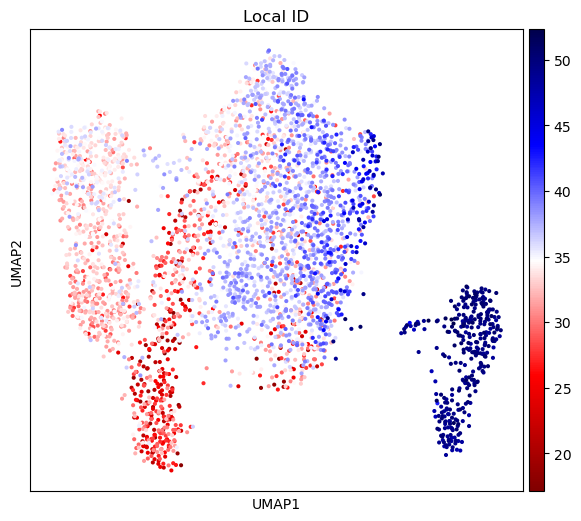

<Figure size 640x480 with 0 Axes>

In [179]:
fig, ax = plt.subplots(figsize=(7, 6))

sc.pl.umap(adata_fbs, color=['local_ID'], title = 'Local ID', color_map = 'seismic_r', alpha=1.,  ax=ax)

plt.tight_layout()
plt.show()

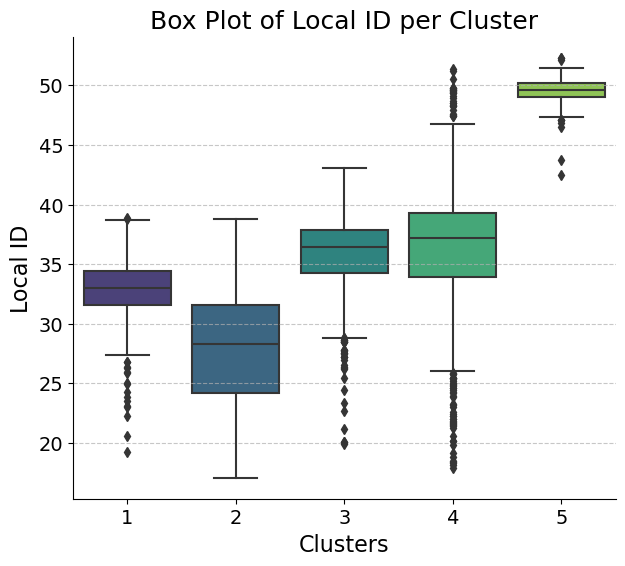

In [189]:
plt.figure(figsize=(7, 6))
sns.boxplot(data=adata_fbs.obs, x="cluster", y="local_ID", palette='viridis')

plt.xlabel("Clusters", fontsize=16)
plt.ylabel("Local ID", fontsize=16)
plt.title("Box Plot of Local ID per Cluster", fontsize=18)

# Imposta xticks e yticks più grandi
plt.xticks(ticks=range(5), labels=['1', '2', '3', '4', '5'], fontsize=14)
plt.yticks(fontsize=14)

# Aggiunta della griglia orizzontale
plt.grid(axis='y', linestyle='--', alpha=0.7)

sns.despine()
plt.show()

In [190]:
n_neighbors = 300
IDs_a2s = compute_ID(adata_a2s, method='local_2nn', n_samples = len(adata_a2s), n_neighbors = n_neighbors, full_output = True)
adata_a2s = add_local_ID_to_adata(adata_a2s, IDs_a2s)

Computing ID for all ID:


Computing Intrinsic Dimension: 100%|██████████| 1/1 [10:36<00:00, 636.96s/it]


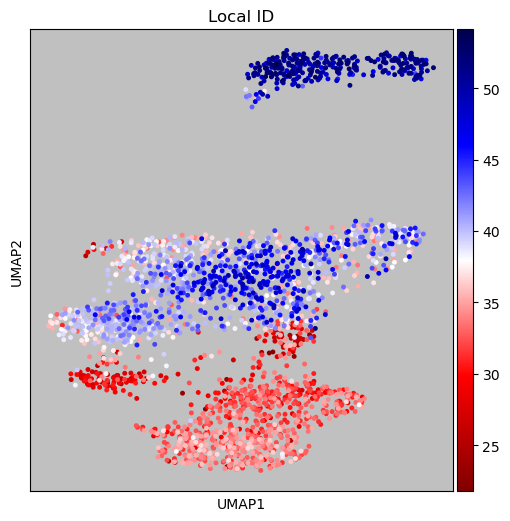

<Figure size 640x480 with 0 Axes>

In [191]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.set_facecolor('silver')

sc.pl.umap(adata_a2s, color=['local_ID'], title = 'Local ID', color_map = 'seismic_r', alpha=1.,  ax=ax, components = ['1,2'])

plt.tight_layout()
plt.show()


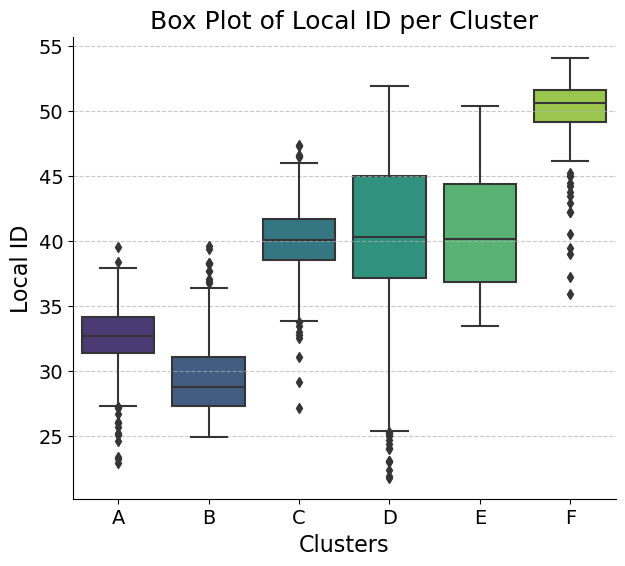

In [194]:
plt.figure(figsize=(7, 6))
sns.boxplot(data=adata_a2s.obs, x="cluster", y="local_ID", palette='viridis')

plt.xlabel("Clusters", fontsize=16)
plt.ylabel("Local ID", fontsize=16)
plt.title("Box Plot of Local ID per Cluster", fontsize=18)

# Imposta xticks e yticks più grandi
plt.xticks(ticks=range(6), labels=['A', 'B', 'C', 'D', 'E', 'F'], fontsize=14)
plt.yticks(fontsize=14)

# Aggiunta della griglia orizzontale
plt.grid(axis='y', linestyle='--', alpha=0.7)

sns.despine()
plt.show()

## Nair 

In [87]:
adata = sc.read('/Users/maddalenastaiano/Desktop/data/Nair.h5ad')

In [15]:
n_samples = 30000
n_neighbors = 600
IDs_nair = compute_ID(adata, method='local_2nn', n_samples = n_samples, n_neighbors = n_neighbors, full_output = True)
adata = add_local_ID_to_adata(adata, IDs_nair)

Computing Intrinsic Dimension:   0%|          | 0/1 [00:00<?, ?it/s]

Computing ID for all ID:


Computing Intrinsic Dimension:   0%|          | 0/1 [14:30<?, ?it/s]


KeyboardInterrupt: 

In [85]:
IDs_nair = pd.read_csv('/Users/maddalenastaiano/Desktop/data/ID_nair_dataframe_localID.csv')

In [89]:
adata

AnnData object with n_obs × n_vars = 59378 × 14889
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.oskm', 'cluster', 'umap1', 'umap2', 'barcode_sample', 'day', 'local_ID'
    var: 'n_cells'
    uns: 'cluster_colors', 'day_colors', 'sample_colors'
    obsm: 'X_umap'

In [90]:
IDs_nair

,Unnamed: 0,ID
0,GGAGAACAGGAAACGA-2,11.107483
1,GTCGCGACAATAGTCC-7,40.451753
2,TATCTTGCAGGCTATT-9,49.432069
3,GGCACGTCAGTGTGCC-4,30.946520
4,TTGAACGTCTGAGAAA-8,39.866699
...,...,...
29995,GGTTGTACACCGCTAG-6,36.605686
29996,CAAGGGATCTCTTAAC-7,33.094712
29997,TCGGTCTCAGGACTTT-8,29.118496
29998,CTTGATTTCTTGTGCC-2,23.703487


In [91]:
adata_nair_localID = sc.read('/Users/maddalenastaiano/Desktop/data/Nair_local_ID.h5ad')

In [94]:
adata_nair_localID.obs

,nCount_RNA,nFeature_RNA,percent.mt,percent.oskm,cluster,umap1,umap2,barcode_sample,day,local_ID
AAACCCAAGAGTGACC-1,13707,3472,4.238710,0.007296,1,-2.259537,-12.160673,AAACCCAAGAGTGACC-1,D0,NaN
AAACCCAAGTGCCAGA-1,12326,3497,5.719617,0.016226,1,-2.600204,-11.891444,AAACCCAAGTGCCAGA-1,D0,36.939498
AAACCCACACCATTCC-1,14442,3996,4.216867,0.013848,1,-2.603581,-10.976259,AAACCCACACCATTCC-1,D0,48.287704
AAACCCACACGCGTCA-1,8813,2793,4.788381,0.011347,1,-0.099734,-13.193298,AAACCCACACGCGTCA-1,D0,47.600051
AAACCCAGTCCATAGT-1,12115,3263,6.009080,0.000000,1,-0.255222,-11.648086,AAACCCAGTCCATAGT-1,D0,34.800390
...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCACATCCCT-9,2143,1173,9.892674,0.093327,15,11.010503,0.818644,TTTGGTTCACATCCCT-9,iPSC,37.534448
TTTGGTTGTTGCCTAA-9,16737,4542,6.512517,0.221067,15,12.799972,-1.049144,TTTGGTTGTTGCCTAA-9,iPSC,45.060413
TTTGGTTTCTCTTAAC-9,6256,2156,6.106138,0.335678,15,10.624118,0.361520,TTTGGTTTCTCTTAAC-9,iPSC,48.897029
TTTGTTGGTAGTGTGG-9,11165,2971,2.857143,0.223914,15,11.254633,-0.278036,TTTGTTGGTAGTGTGG-9,iPSC,NaN


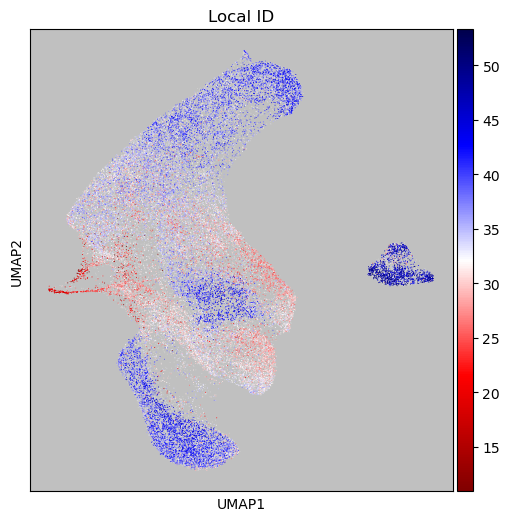

<Figure size 640x480 with 0 Axes>

In [97]:

fig, ax = plt.subplots(figsize=(6, 6))

ax.set_facecolor('silver')
sc.pl.umap(adata_nair_localID, color=['local_ID'], title = 'Local ID', color_map = 'seismic_r', alpha=1., ax = ax)

plt.tight_layout()
plt.show()



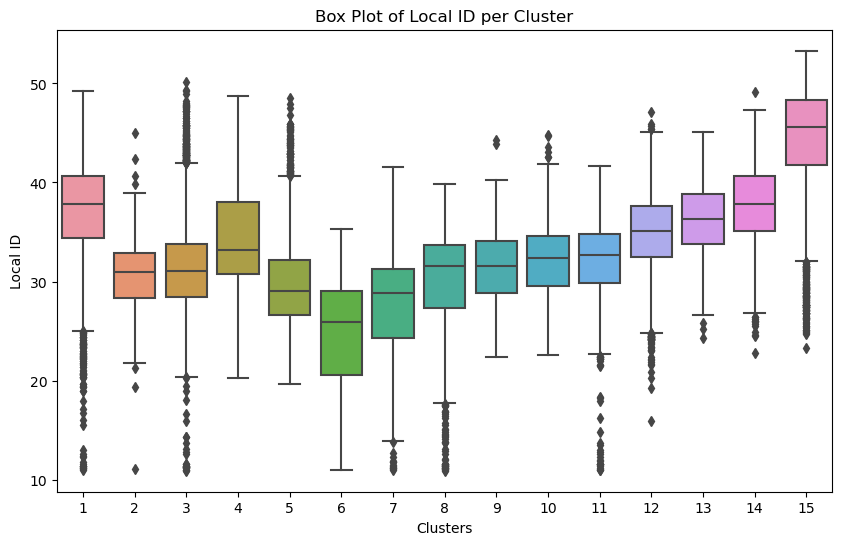

In [148]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=adata_nair_localID.obs, x="cluster", y="local_ID")

plt.xlabel("Clusters")
plt.ylabel("Local ID")
plt.title("Box Plot of Local ID per Cluster")
plt.show()

In [105]:
adata_nair_localID

AnnData object with n_obs × n_vars = 59378 × 14889
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.oskm', 'cluster', 'umap1', 'umap2', 'barcode_sample', 'day', 'local_ID'
    var: 'n_cells'
    uns: 'cluster_colors', 'day_colors', 'sample_colors'
    obsm: 'X_umap'

In [112]:
range(len(clusters))

range(0, 4)

In [122]:
adata_nair_localID.obs.cluster

AnnData object with n_obs × n_vars = 59378 × 14889
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.oskm', 'cluster', 'umap1', 'umap2', 'barcode_sample', 'day', 'local_ID'
    var: 'n_cells'
    uns: 'cluster_colors', 'day_colors', 'sample_colors'
    obsm: 'X_umap'

In [149]:
subset = adata_nair_localID[adata_nair_localID.obs["cluster"].isin(clusters_groups[i])]

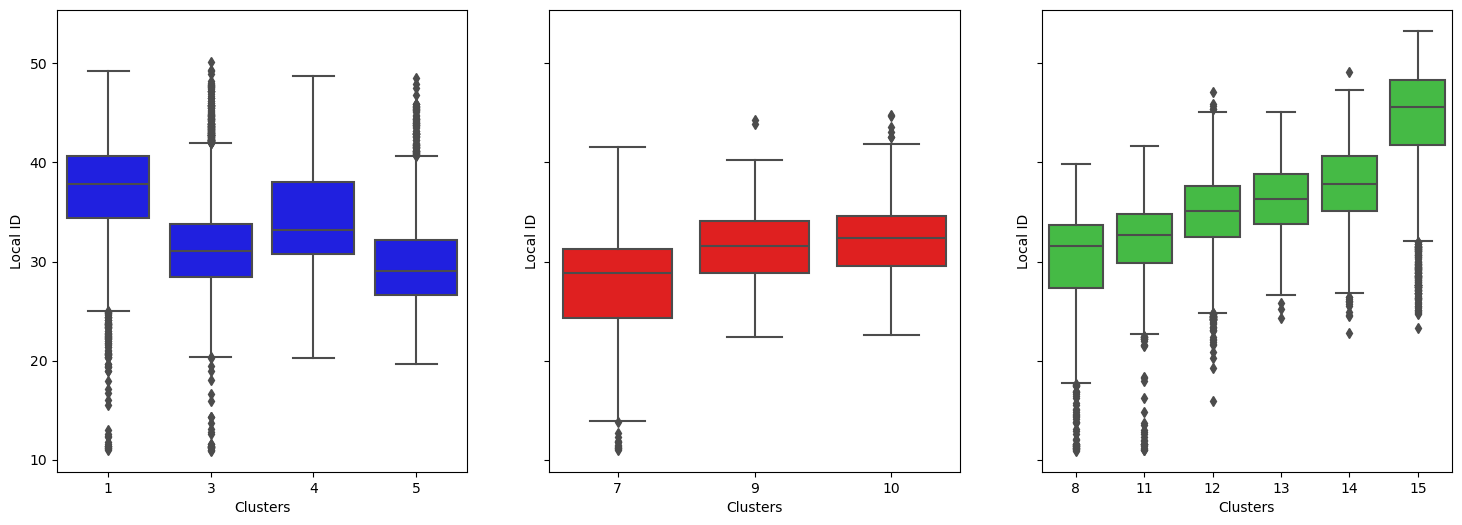

In [169]:
clusters_groups = [['1', '3', '4', '5'], ['7','9', '10'], ['8', '11', '12', '13', '14', '15']]
colors = ['blue', "red", "limegreen"]

fig, axes =  plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, col in zip(range(3), colors):

    subset = adata_nair_localID[adata_nair_localID.obs["cluster"].isin(clusters_groups[i])]
    sns.boxplot(data=subset.obs, x="cluster", y="local_ID", color = col, ax = axes[i], boxprops = dict(alpha = 1))

    axes[i].set_xlabel("Clusters")
    axes[i].set_ylabel("Local ID")

In [147]:
subset[subset.cluster == clus].local_ID.values

array([ nan,  nan,  nan, ..., 48.9,  nan,  nan])

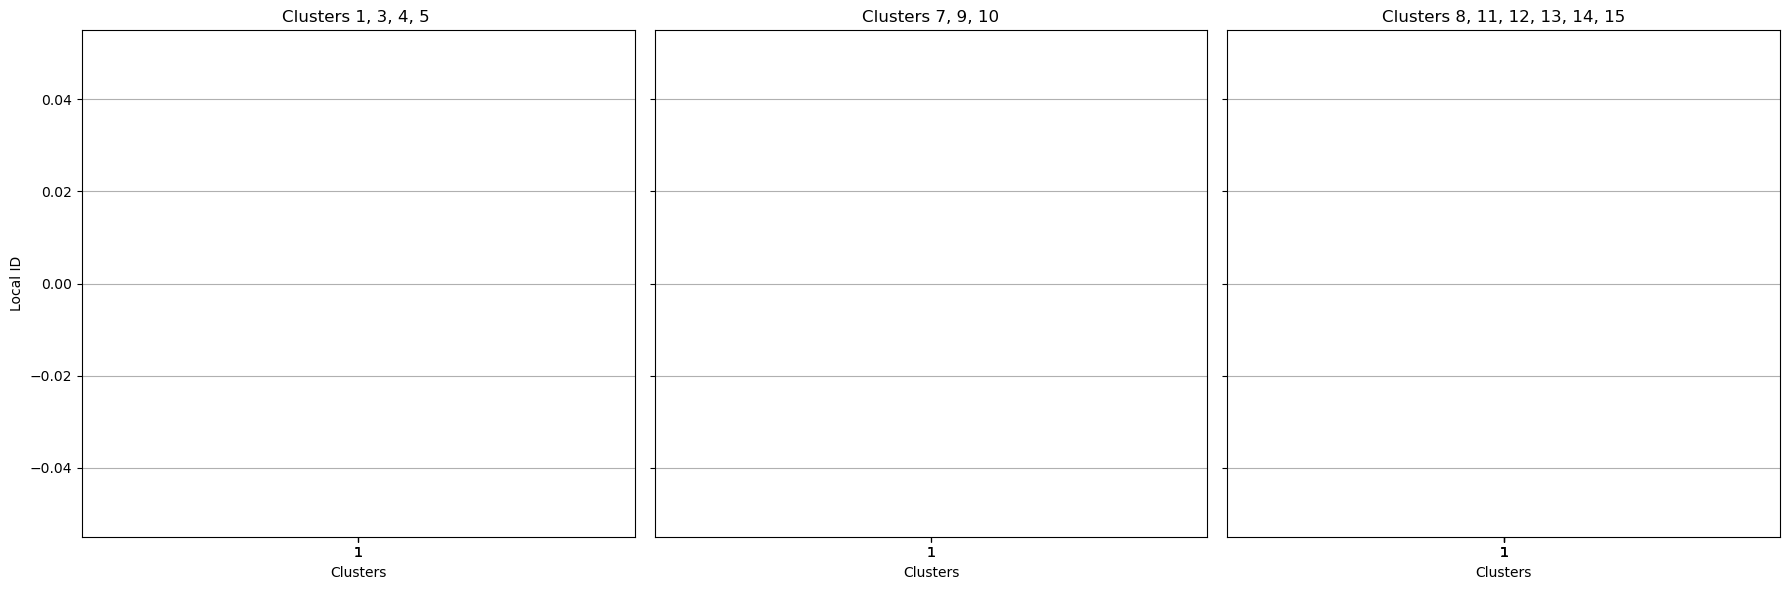

In [145]:

clusters_groups = [['1', '3', '4', '5'], ['7','9', '10'], ['8', '11', '12', '13', '14', '15']]
colors = ['b', "orangered", "limegreen"]
titles = ["Clusters 1, 3, 4, 5 ", "Clusters 7, 9, 10", "Clusters 8, 11, 12, 13, 14, 15"]


fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)


for i, (clusters, color) in enumerate(zip(clusters_groups, colors)):

    subset = adata_nair_localID.obs[adata_nair_localID.obs["cluster"].isin(clusters)]
    for l,clus in enumerate(subset.cluster.unique()):
        axes[i].boxplot(subset[subset.cluster == clus].local_ID.values)
    #axes[i].boxplot(range(len(cluster)),subset.local_ID.values)#data=subset, x="local_ID", color=color)
    
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("Clusters")
    axes[i].set_ylabel("Local ID" if i == 0 else "") 
    axes[i].yaxis.grid(True) 

plt.tight_layout()
plt.show()




## Xenopus

In [4]:
adata_xen = sc.read('/Users/maddalenastaiano/Desktop/data/xenopus_correct.h5ad')

In [5]:
adata_xen.obs

,orig.ident,nCount_RNA,nFeature_RNA,stim,isnt,integrated_snn_res.0.5,seurat_clusters
AAACCCAGTCTGCAAT.1,SIGAH5,37778.0,5842,SIGAH5,IVF,6,6
AAACGAACAAACCACT.1,SIGAH5,89539.0,8284,SIGAH5,IVF,0,0
AAACGCTAGGTTGTTC.1,SIGAH5,50225.0,6607,SIGAH5,IVF,3,3
AAACGCTCACTTGGCG.1,SIGAH5,60572.0,7252,SIGAH5,IVF,8,8
AAAGAACGTCAAAGAT.1,SIGAH5,53523.0,6700,SIGAH5,IVF,5,5
...,...,...,...,...,...,...,...
TTTACCATCCGTCCTA.1,SIGAB2,48420.0,8064,SIGAB2,NT,8,8
TTTCAGTGTACGATCT.1,SIGAB2,21383.0,5811,SIGAB2,NT,0,0
TTTCCTCCAGCCCAGT.1,SIGAB2,22628.0,5751,SIGAB2,NT,7,7
TTTGTTGCAAGTCGTT.1,SIGAB2,33055.0,7074,SIGAB2,NT,1,1


/Users/maddalenastaiano/opt/anaconda3/envs/pancreas/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/maddalenastaiano/opt/anaconda3/envs/pancreas/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


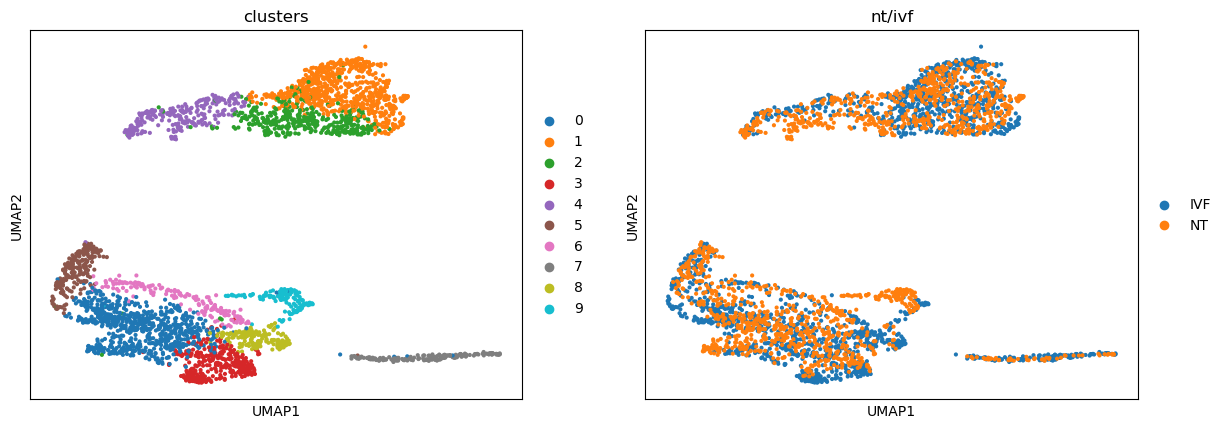

In [6]:
sc.pl.umap(adata_xen, color=['seurat_clusters', 'isnt'], title = ['clusters', 'nt/ivf'], alpha=1.)

In [7]:
adata_ivf = adata_xen[adata_xen.obs.isnt == 'IVF']
adata_nt = adata_xen[adata_xen.obs.isnt == 'NT']

/Users/maddalenastaiano/opt/anaconda3/envs/pancreas/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/maddalenastaiano/opt/anaconda3/envs/pancreas/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


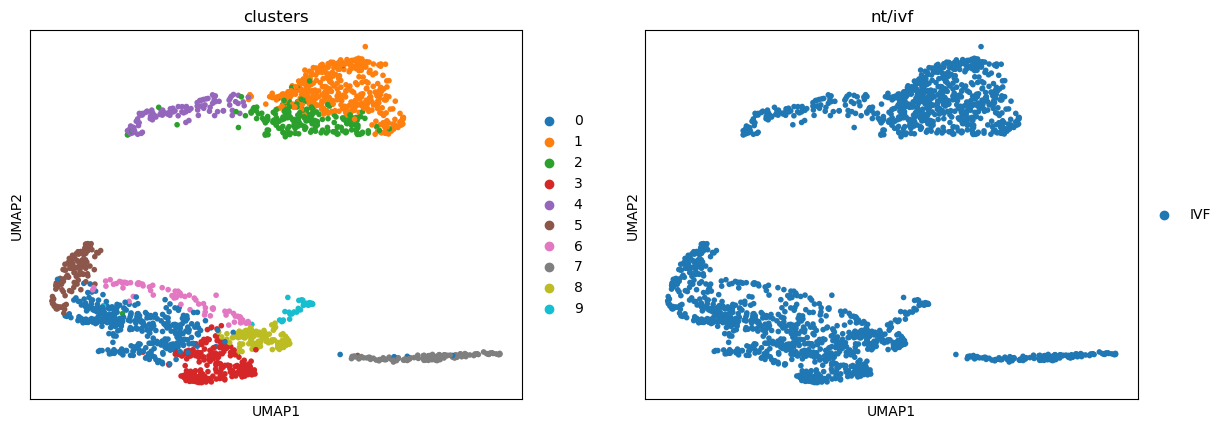

In [8]:
sc.pl.umap(adata_ivf, color=['seurat_clusters', 'isnt'], title = ['clusters', 'nt/ivf'], alpha=1.)

### ID separating IVT and NT cells

In [9]:
n_neighbors = 150
IDs_ivf = compute_ID(adata_ivf, method='local_2nn', n_samples = len(adata_ivf), n_neighbors = n_neighbors, full_output = True)
IDs_nt = compute_ID(adata_nt, method='local_2nn', n_samples = len(adata_nt), n_neighbors = n_neighbors, full_output = True)
adata_ivf = add_local_ID_to_adata(adata_ivf,IDs_ivf)
adata_nt = add_local_ID_to_adata(adata_nt,IDs_nt)

Computing Intrinsic Dimension:   0%|          | 0/1 [00:00<?, ?it/s]

Computing ID for all ID:


Computing Intrinsic Dimension:   0%|          | 0/1 [00:00<?, ?it/s]

Computing ID for all ID:


Computing Intrinsic Dimension: 100%|██████████| 1/1 [05:14<00:00, 314.71s/it]
/var/folders/hh/d5yl6z994mzbfn58khq3smpc0000gn/T/ipykernel_72815/3912101523.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  Adata.obs['local_ID'] = pd.NA
/var/folders/hh/d5yl6z994mzbfn58khq3smpc0000gn/T/ipykernel_72815/3912101523.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  Adata.obs['local_ID'] = pd.NA


In [10]:
print(f'IVF  -->  min value: {IDs_ivf.ID.values.min()}      max value {IDs_ivf.ID.values.max()} ')
print(f'NT  -->  min value: {IDs_nt.ID.values.min()}      max value {IDs_nt.ID.values.max()} ')
minvalue = min(IDs_ivf.ID.values.min(), IDs_nt.ID.values.min())
maxvalue = max(IDs_ivf.ID.values.max(), IDs_nt.ID.values.max())
print(f'min : {minvalue}, max : {maxvalue}')


IVF  -->  min value: 16.481102233085977      max value 43.93337771602801 
NT  -->  min value: 4.254108872240635      max value 46.056525202158724 
min : 4.254108872240635, max : 46.056525202158724


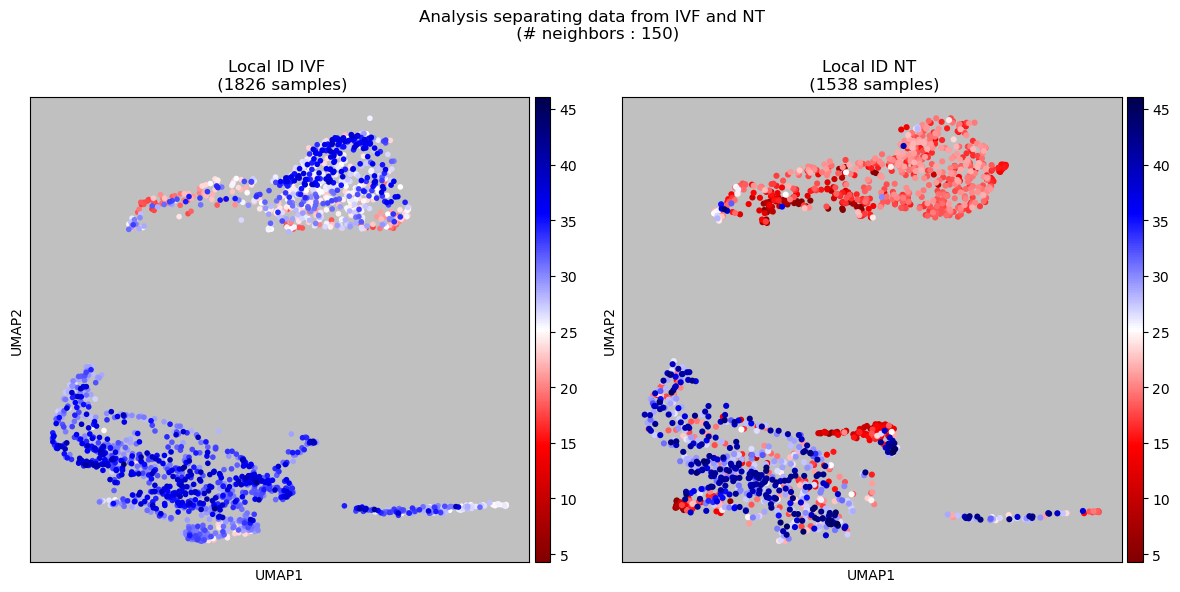

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle('Analysis separating data from IVF and NT \n (# neighbors : 150)')

axes[0].set_facecolor('silver')
axes[1].set_facecolor('silver')

sc.pl.umap(adata_ivf, color='local_ID', title='Local ID IVF \n (1826 samples)', color_map='seismic_r', alpha=1., ax=axes[0], show=False, vmin = minvalue, vmax = maxvalue)
sc.pl.umap(adata_nt, color='local_ID', title='Local ID NT \n (1538 samples)', color_map='seismic_r', alpha=1., ax=axes[1], show=False, vmin = minvalue, vmax = maxvalue)

plt.tight_layout()
plt.show()

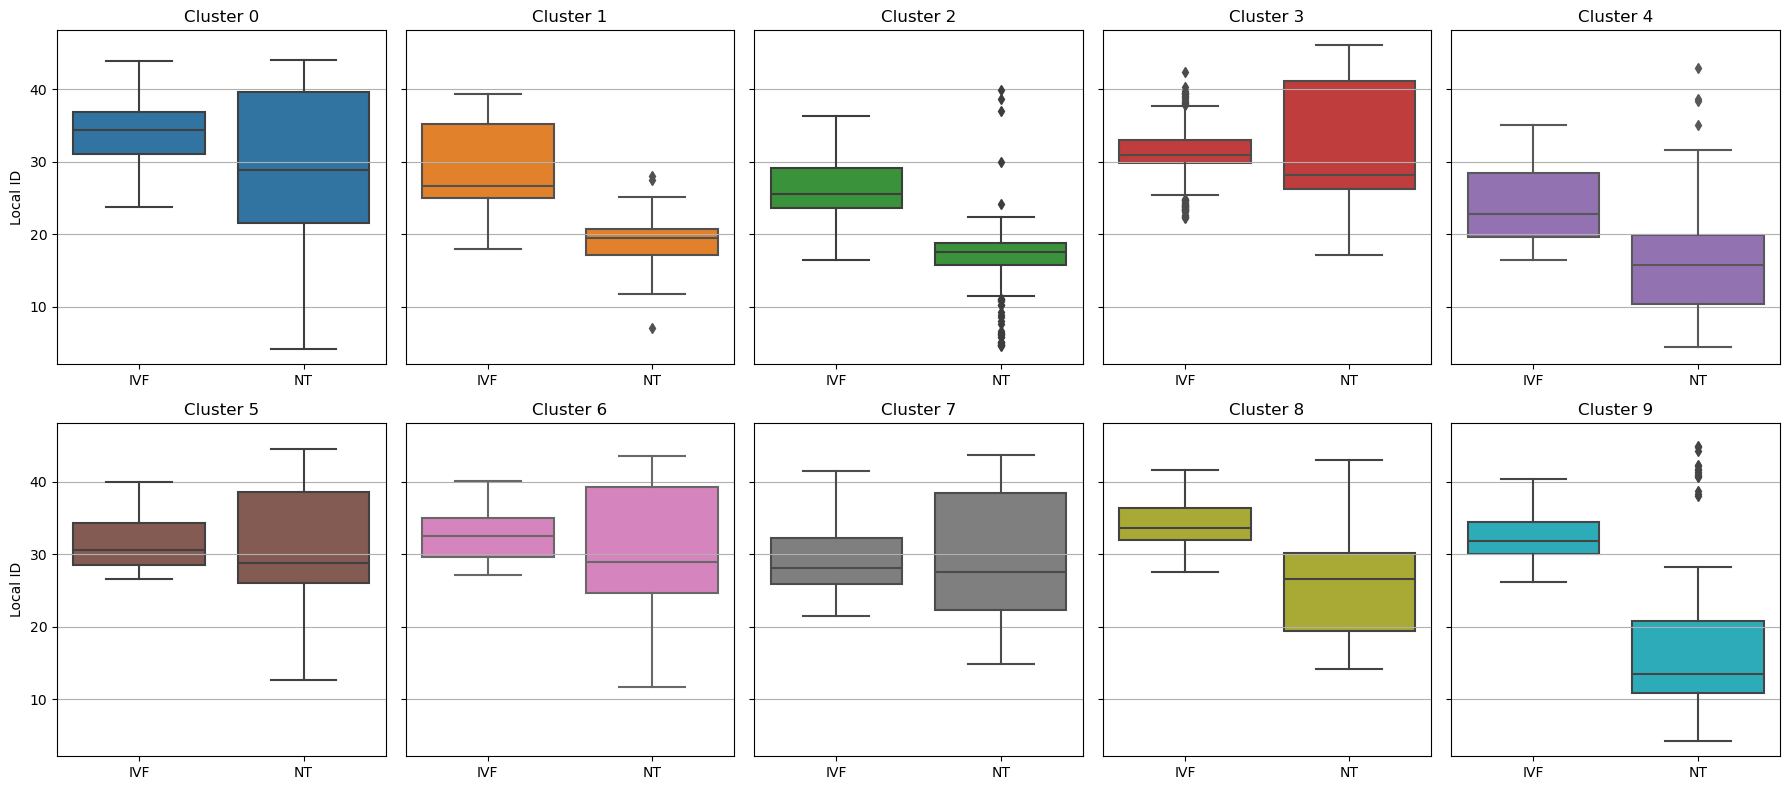

In [12]:
plot_clusters_boxplot(adata_ivf, adata_nt)

### ID on all cells together

In [72]:
n_neighbors = 150
IDs_xen = compute_ID(adata_xen, method='local_2nn', n_samples = len(adata_xen), n_neighbors = n_neighbors, full_output = True)


Computing Intrinsic Dimension:   0%|          | 0/1 [00:00<?, ?it/s]

Computing ID for all ID:


Computing Intrinsic Dimension: 100%|██████████| 1/1 [17:35<00:00, 1055.75s/it]


In [75]:
add_local_ID_to_adata(adata_xen, IDs_xen)

AnnData object with n_obs × n_vars = 3364 × 31179
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'isnt', 'integrated_snn_res.0.5', 'seurat_clusters', 'local_ID'
    var: 'features'
    uns: 'isnt_colors', 'seurat_clusters_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [80]:

adata_xen_ivf = adata_xen[adata_xen.obs.isnt == 'IVF']
adata_xen_nt = adata_xen[adata_xen.obs.isnt == 'NT']

/var/folders/hh/d5yl6z994mzbfn58khq3smpc0000gn/T/ipykernel_30531/1636491519.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_ivf.obs["local_ID"] = pd.to_numeric(adata_ivf.obs["local_ID"], errors="coerce")
/var/folders/hh/d5yl6z994mzbfn58khq3smpc0000gn/T/ipykernel_30531/1636491519.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_nt.obs["local_ID"] = pd.to_numeric(adata_nt.obs["local_ID"], errors="coerce")


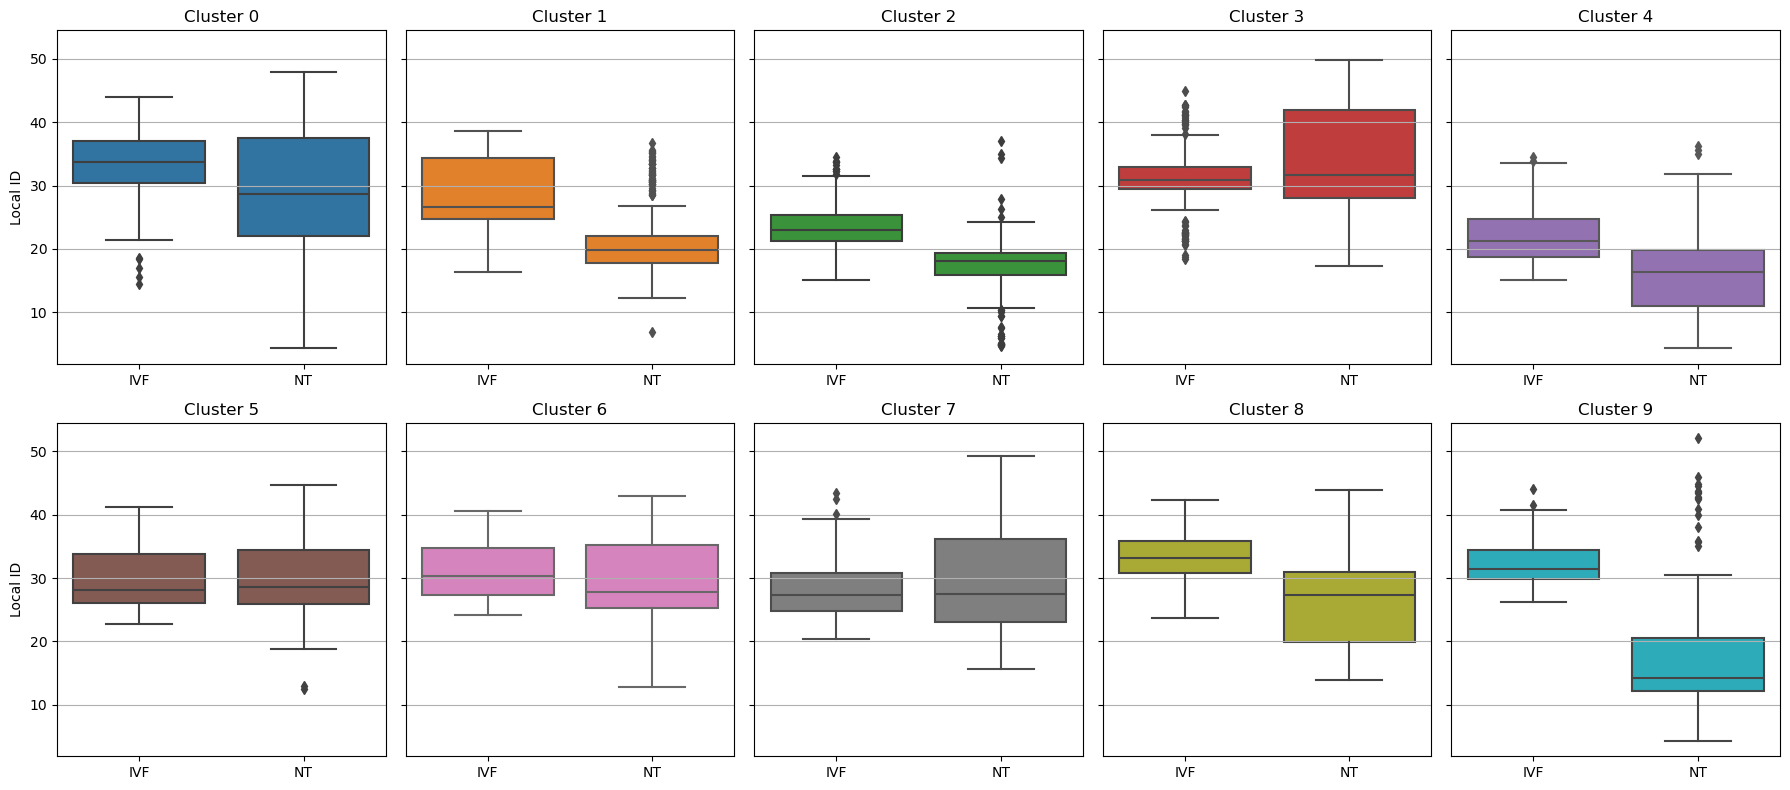

In [81]:
plot_clusters_boxplot(adata_xen_ivf, adata_xen_nt)

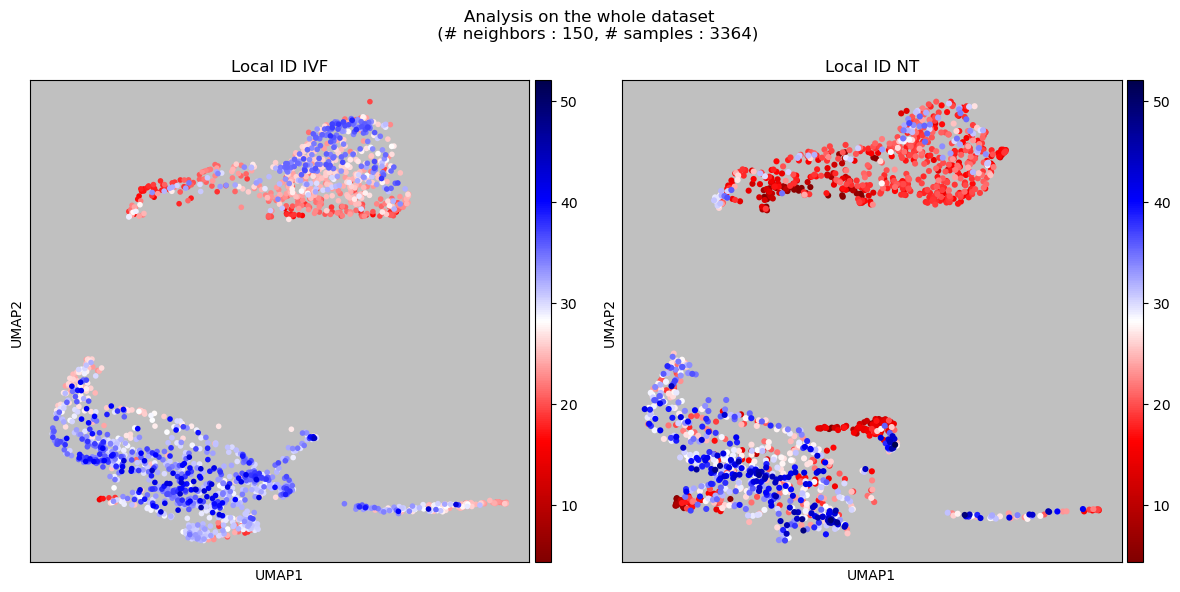

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle('Analysis on the whole dataset  \n (# neighbors : 150, # samples : 3364)')

axes[0].set_facecolor('silver')
axes[1].set_facecolor('silver')

min = IDs_xen.ID.values.min()
max = IDs_xen.ID.values.max()
sc.pl.umap(adata_xen[adata_xen.obs.isnt == 'IVF'], color='local_ID', title='Local ID IVF', color_map='seismic_r', alpha=1., ax=axes[0], show=False, vmin = min,  vmax = max)
sc.pl.umap(adata_xen[adata_xen.obs.isnt == 'NT'], color='local_ID', title='Local ID NT', color_map='seismic_r', alpha=1., ax=axes[1], show=False, vmin = min,  vmax = max)

plt.tight_layout()
plt.show()

/var/folders/hh/d5yl6z994mzbfn58khq3smpc0000gn/T/ipykernel_89276/2540953238.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', 20)


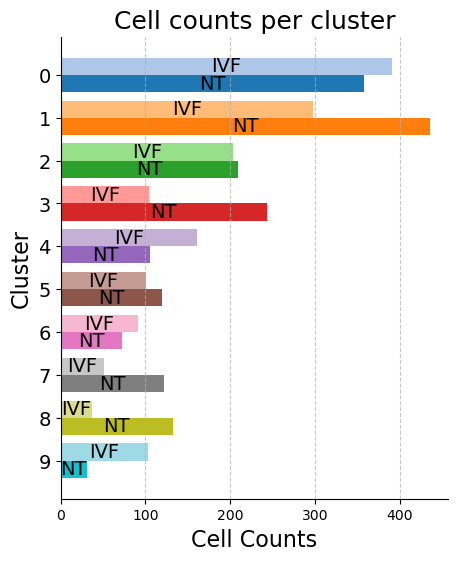

In [119]:
# cell counts per cluster

clusters, counts_NT =  np.unique(adata_xen[adata_xen.obs['isnt']=='NT'].obs['seurat_clusters'], return_counts = True)
clusters, counts_IVF = np.unique(adata_xen[adata_xen.obs['isnt']=='IVF'].obs['seurat_clusters'], return_counts = True)
x = np.arange(len(clusters))
l = 0.4
colors = plt.cm.get_cmap('tab20', 20)  
odd_indices = np.arange(1, 20, 2)
even_indices = np.arange(0, 20, 2)

plt.figure(figsize=(5, 6)) 
bars_NT = plt.barh(x - l/2, counts_NT, height=l, color=colors(odd_indices))
bars_IVF = plt.barh(x + l/2, counts_IVF, height=l, color=colors(even_indices))

plt.gca().invert_yaxis()

plt.xlabel("Cell Counts", fontsize=16)  
plt.ylabel("Cluster", fontsize=16)  
plt.title("Cell counts per cluster", fontsize=18)  

for bar in bars_NT:
    plt.text(bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, 'IVF', va='center', ha='center', fontsize=14, color='black')

for bar in bars_IVF:
    plt.text(bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, 'NT', va='center', ha='center', fontsize=14, color='black')

plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.yticks(np.arange(0, 10, 1), fontsize=14)  
sns.despine()
plt.show()
